# Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of a traffic sign image?
image_shape = X_train[0].shape

# Number of unique classes/labels in the dataset
n_classes = max(y_train) - min(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Histogram of available training road signs


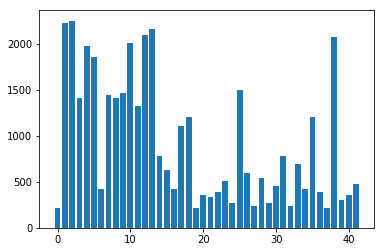

[ 0 37 19 32 27 29 24 39 21 40 20 36 22 34 16  6 30 41 23 28 26 15 33 31 14
 17 35 18 11  8  3  7  9 25  5  4 10 38 12 13  1  2]
35


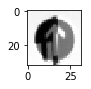

In [3]:
### Data exploration visualization
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Convert rgb pictures to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.5870, 0.1140])

hist, bounds = np.histogram(y_train, np.arange(n_classes))
print("Histogram of available training road signs")
plt.bar(np.arange(n_classes - 1), hist)
plt.show()

min_hists = hist.argsort()
print(min_hists)

# convert the samples to grey-scale
X_grey = rgb2gray(X_train)
X_grey = np.reshape(X_grey, (-1, 32, 32, 1))
index = random.randint(0, n_train)
image = X_grey[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## Extra Step: Extend Training Set

In [4]:
# find all images in training set whose lable is in the list above
# 0 37 19 32 27 29 24 39 21 40
# thse 10 classes were found to have the least number of training samples
import cv2

indices_0  = [i for i, x in enumerate(y_train) if x == 0]
indices_19 = [i for i, x in enumerate(y_train) if x == 19]
indices_21 = [i for i, x in enumerate(y_train) if x == 21]
indices_24 = [i for i, x in enumerate(y_train) if x == 24]
indices_27 = [i for i, x in enumerate(y_train) if x == 27]
indices_29 = [i for i, x in enumerate(y_train) if x == 29]
indices_32 = [i for i, x in enumerate(y_train) if x == 32]
indices_37 = [i for i, x in enumerate(y_train) if x == 37]
indices_39 = [i for i, x in enumerate(y_train) if x == 39]
indices_40 = [i for i, x in enumerate(y_train) if x == 40]

def extend_training(index, lable):
    global X_grey, y_train
    image = X_grey[index[:]].squeeze()
    count = len(image)

    for i in range(count):
        resized_image = cv2.resize(image[i],(40, 40))
        image = np.append(image, [resized_image[4:36,4:36]], axis=0)
        y_train = np.append(y_train, [lable], axis=0)

    rows,cols = 32,32
    M5 = cv2.getRotationMatrix2D((cols/2,rows/2),5,1)
    Mm5 = cv2.getRotationMatrix2D((cols/2,rows/2),-5,1)

    for i in range(count):
        rotated_5_image = cv2.warpAffine(image[i],M5,(cols,rows))
        rotated_m5_image = cv2.warpAffine(image[i],Mm5,(cols,rows))
        image = np.append(image, [rotated_5_image], axis=0)
        y_train = np.append(y_train, [lable], axis=0)
        image = np.append(image, [rotated_m5_image], axis=0)
        y_train = np.append(y_train, [lable], axis=0)

    image = image[count:,...]

    X_grey = np.append(X_grey, np.reshape(image, (-1, 32, 32, 1)), axis=0)

extend_training(indices_0 , 0 )
extend_training(indices_19, 19)
extend_training(indices_21, 21)
extend_training(indices_24, 24)
extend_training(indices_27, 27)
extend_training(indices_29, 29)
extend_training(indices_32, 32)
extend_training(indices_37, 37)
extend_training(indices_39, 39)
extend_training(indices_40, 40)

# normalize training set for the newly added elements. 
X_grey = (X_grey - 128)/128

print(len(y_train))
print(X_grey.shape)

47129
(47129, 32, 32, 1)


Histogram of available training road signs


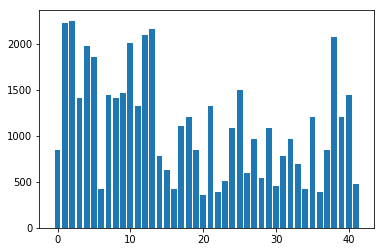

In [5]:
hist, bounds = np.histogram(y_train, np.arange(n_classes))
print("Histogram of available training road signs")
plt.bar(np.arange(n_classes - 1), hist)
plt.show()


## Step 2: Design and Test a Model Architecture

In [6]:
### Preprocess the data
from sklearn.model_selection import train_test_split

x_trn, x_val, y_trn, y_val = train_test_split(X_grey, y_train, test_size=0.2)

# Number of training examples
n_trn = len(x_trn)

# Number of validation examples
n_val = len(x_val)

# Number of testing examples.
n_test = len(X_test)

print("Number of training examples =", n_trn)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)

Number of training examples = 37703
Number of validation examples = 9426
Number of testing examples = 12630


In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

EPOCHS = 10
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W_L1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    b_L1 = tf.Variable(tf.zeros(6))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    L1_out = tf.nn.conv2d(x, W_L1, strides, padding) + b_L1

    # Activation.
    L1_out = tf.tanh(L1_out)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    P1_out = tf.nn.max_pool(L1_out, ksize, strides, padding)

    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    W_L2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    b_L2 = tf.Variable(tf.zeros(16))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    L2_out = tf.nn.conv2d(P1_out, W_L2, strides, padding) + b_L2

    # Activation.
    L2_out = tf.tanh(L2_out)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    P2_out = tf.nn.max_pool(L2_out, ksize, strides, padding)

    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(P2_out)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    W_L3 = tf.Variable(tf.truncated_normal(shape = (400, 120), mean = mu, stddev = sigma))
    b_L3 = tf.Variable(tf.zeros(120))
    L3_out = tf.add(tf.matmul(flat, W_L3), b_L3)
    
    # Activation.
    L3_out = tf.tanh(L3_out)
    L3_out = tf.nn.dropout(L3_out, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W_L4 = tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma))
    b_L4 = tf.Variable(tf.zeros(84))
    L4_out = tf.add(tf.matmul(L3_out, W_L4), b_L4)
    
    # Activation.
    L4_out = tf.tanh(L4_out)
    L4_out = tf.nn.dropout(L4_out, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    W_L5 = tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))
    b_L5 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(L4_out, W_L5), b_L5)
    
    return logits

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units in drop out
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = n_trn
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_trn, y_trn = shuffle(x_trn, y_trn)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_trn[offset:end], y_trn[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.6})
            
        validation_accuracy = evaluate(x_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.812

EPOCH 2 ...
Validation Accuracy = 0.902

EPOCH 3 ...
Validation Accuracy = 0.946

EPOCH 4 ...
Validation Accuracy = 0.963

EPOCH 5 ...
Validation Accuracy = 0.967

EPOCH 6 ...
Validation Accuracy = 0.974

EPOCH 7 ...
Validation Accuracy = 0.978

EPOCH 8 ...
Validation Accuracy = 0.979

EPOCH 9 ...
Validation Accuracy = 0.981

EPOCH 10 ...
Validation Accuracy = 0.984

Model saved


---
### Question 1 
_Describe how you preprocessed the data. Why did you choose that technique?_

### Answer
I have 5 preprocessing steps:
1. Convert color images to grayscale 
X_grey = rgb2gray(X_train)
2. Adjust the shape of images to be (32, 32, 1) to be compatible with tensorflow
X_grey = np.reshape(X_grey, (-1, 32, 32, 1))
3. Added more data to the training set
4. Normalize the training images by subtracting and deviding by 128.
5. Using 'train_test_split' from 'sklearn.model_selection' split the training set into training and verification sets. This library also shuffles the output sets by default.

---
### Question 2
_Describe how you set up the training, validation and testing data for your model. Optional: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

### Answer
The histogram suggest very uneven distribution of training data. I picked the 10 lables with smallest number of training images and augmented those.
In order to generate new images, for each image with lable defined above I did:
- Resized grey-scale image to be 40x40 and then removed 4 rows and columns from top, buttom, left and right of the image. This ensures the middle section of the image is zoomed, while keeping the original 32x32 size of the image.
- Rotate the image once 5 and once -5 degrees.
All in all, each image will have 3 other images in the training set.
The input data to the program is training vs. test. I used train_test_split on the training data to split it for training and validation. The test data is ultimately used for testing purposes.

---
### Question 3
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

### Answer
The architecture is very similar to the LeNet network introduced in the lesson. This is the breakdown of the architecture:
* Layer 1: Convolutional layer. 
 * Input=32x32x1. Filter size=5x5. Output=28x28x6. Valid Padding.
 * Activation: tanh
 * Max Pooling. Input=28x28x6. Filter Size=2x2. Output=14x14x6. Valid Padding.

* Layer 2: Convolutional layer. 
 * Input=14x14x6. Filter size=5x5. Output=10x10x16. Valid Padding.
 * Activation: tanh
 * Max Pooling. Input=10x10x16. Filter Size=2x2. Output=5x5x16. Valid Padding.
 * Flattening Layer: Input=5x5x16. Output=400.

* Layer 3: Fully Connected.
 * Input=400. Output=120.
 * Activation: tanh
 * Dropout

* Layer 4: Fully Connected.
 * Input=120. Output=84.
 * Activation: tanh
 * Dropout

* Layer 5: Fully Connected.
 * Input=84. Output=43.


---
### Question 4
_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

### Answer
I used Adam optimizer with learning rate of 0.001. The training was done in 10 epochs with batch size of 128. Also, for training a drop out with probability of 0.4 was used (keep probability of 0.6).

---
### Question 5
_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

### Answer
I used the LeNet architecture as the base for the model. I used tanh (instead of ReLU) activation and RGB to Gray scale from the paper referred to in the description of the project.
Drop out probability of 0.3 was found based on trial and error. Number of epochs and batch sizes was not changed from the default value.
I also tried the average pooling instead of max pooling but the result was worst.
I also found out that applying drop out to all levels of the model is a very bad idea, so it was just used in the fully connected layers.
I also figured out that normalization improves the accuracy (hinted in the paper as well).

## Step 3: Test a Model on New Images

Histogram of test samples


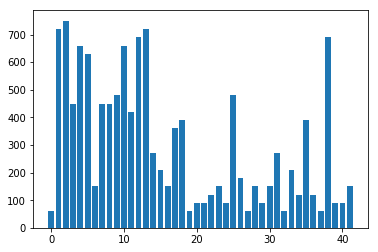

Test Accuracy = 0.935


In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# convert the test samples to grey-scale
X_grey_test = rgb2gray(X_test)

# normalize the test samples
X_grey_test = (X_grey_test - 128)/128
X_grey_test = np.reshape(X_grey_test, (-1, 32, 32, 1))

# draw the histogram of the test samples
hist, bounds = np.histogram(y_test, np.arange(n_classes))
print("Histogram of test samples")
plt.bar(np.arange(n_classes - 1), hist)
plt.show()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_grey_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---
### Question 6
_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._

### Answer
I have fixed the indexes for a deterministic output. They were generated randomly the first time.
Looking at the images we can see that sun glare, lens out-of-focus and the low resolution of the images might make it hard for the classifier to distinguish between the signs. Most importantly because such features might not be present in the training set.

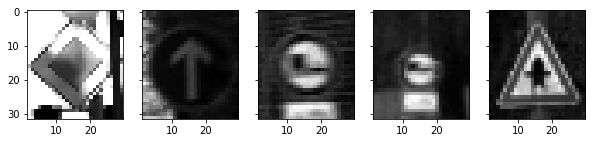

In [10]:
ax = []
f, ax = plt.subplots(1, 5, sharey=True, figsize=(10,2))
cnt = 0
for index in [4084, 6562, 5185, 10237, 9305]:
    image = X_grey_test[index].squeeze()
    ax[cnt].imshow(image, cmap="gray")
    cnt += 1

---
### Question 7
_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

### Answer
Looking at the output of the following code, only one of the detections is correct. So the accuracy in this case is only 20%

classified as: 19 correct class: 21
classified as: 33 correct class: 26
classified as: 1 correct class: 27
classified as: 23 correct class: 30
classified as: 32 correct class: 32


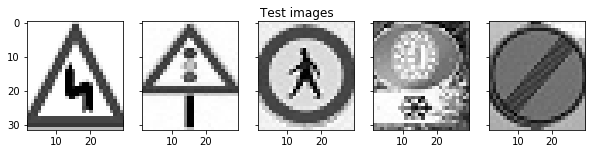

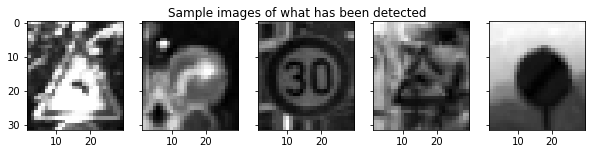

In [11]:
import matplotlib.image as mpimg

def image_transform(image):
    temp = rgb2gray(image)
    temp = (temp - 128)/128
    temp = np.reshape(temp, (-1, 32, 32, 1))
    temp = temp.astype(np.float32)
    return temp

images0 = image_transform(mpimg.imread('test_double_curve_21.png'))
images1 = image_transform(mpimg.imread('test_traffic_signal_26.jpg'))
images2 = image_transform(mpimg.imread('test_pedestrians_27.jpg'))
images3 = image_transform(mpimg.imread('test_beware_ice_snow_30.jpg'))
images4 = image_transform(mpimg.imread('test_all_limits_32.jpeg'))

classes0 = 21
classes1 = 26
classes2 = 27
classes3 = 30
classes4 = 32

f, ax = plt.subplots(1, 5, sharey=True, figsize=(10,2))
f.suptitle("Test images")
ax[0].imshow(images0.squeeze(), cmap="gray")
ax[1].imshow(images1.squeeze(), cmap="gray")
ax[2].imshow(images2.squeeze(), cmap="gray")
ax[3].imshow(images3.squeeze(), cmap="gray")
ax[4].imshow(images4.squeeze(), cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    detected_class = sess.run(tf.argmax(logits, 1), feed_dict={x:images0, keep_prob:1})
    print("classified as:", detected_class[0], "correct class:", classes0)
    index = np.where(y_train == detected_class[0])[0][0]
    image_sample0 = X_grey[index].squeeze()
    
    detected_class = sess.run(tf.argmax(logits, 1), feed_dict={x:images1, keep_prob:1})
    print("classified as:", detected_class[0], "correct class:", classes1)
    index = np.where(y_train == detected_class[0])[0][0]
    image_sample1 = X_grey[index].squeeze()
        
    detected_class = sess.run(tf.argmax(logits, 1), feed_dict={x:images2, keep_prob:1})
    print("classified as:", detected_class[0], "correct class:", classes2)
    index = np.where(y_train == detected_class[0])[0][0]
    image_sample2 = X_grey[index].squeeze()
        
    detected_class = sess.run(tf.argmax(logits, 1), feed_dict={x:images3, keep_prob:1})
    print("classified as:", detected_class[0], "correct class:", classes3)
    index = np.where(y_train == detected_class[0])[0][0]
    image_sample3 = X_grey[index].squeeze()
    
    detected_class = sess.run(tf.argmax(logits, 1), feed_dict={x:images4, keep_prob:1})
    print("classified as:", detected_class[0], "correct class:", classes4)
    index = np.where(y_train == detected_class[0])[0][0]
    image_sample4 = X_grey[index].squeeze()        

    f, ax = plt.subplots(1, 5, sharey=True, figsize=(10,2))
    f.suptitle("Sample images of what has been detected")
    ax[0].imshow(image_sample0.squeeze(), cmap="gray")
    ax[1].imshow(image_sample1.squeeze(), cmap="gray")
    ax[2].imshow(image_sample2.squeeze(), cmap="gray")
    ax[3].imshow(image_sample3.squeeze(), cmap="gray")
    ax[4].imshow(image_sample4.squeeze(), cmap="gray")


---
### Question 8
*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

### Answer
Code below runs the prediction, finds the softmax of the output, outputs the top 5 probabilities and indexes along with the correct class index.

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    find_top_k = tf.nn.top_k(tf.nn.softmax(logits), k = 5)
    
    softout = sess.run(find_top_k, feed_dict={x:images0, keep_prob:1})
    print("Top 5 Probability values:",softout.values[0])
    print("Top 5 Corresponding Classes:",softout.indices[0])
    print("Correct value", classes0)

    softout = sess.run(find_top_k, feed_dict={x:images1, keep_prob:1})
    print("Top 5 Probability values:",softout.values[0])
    print("Top 5 Corresponding Classes:",softout.indices[0])
    print("Correct value", classes1)

    softout = sess.run(find_top_k, feed_dict={x:images2, keep_prob:1})
    print("Top 5 Probability values:",softout.values[0])
    print("Top 5 Corresponding Classes:",softout.indices[0])
    print("Correct value", classes2)

    softout = sess.run(find_top_k, feed_dict={x:images3, keep_prob:1})
    print("Top 5 Probability values:",softout.values[0])
    print("Top 5 Corresponding Classes:",softout.indices[0])
    print("Correct value", classes3)

    softout = sess.run(find_top_k, feed_dict={x:images4, keep_prob:1})
    print("Top 5 Probability values:",softout.values[0])
    print("Top 5 Corresponding Classes:",softout.indices[0])
    print("Correct value", classes4)


Top 5 Probability values: [ 0.11601139  0.11243756  0.09580778  0.08852546  0.07446486]
Top 5 Corresponding Classes: [19 10 11  9 30]
Correct value 21
Top 5 Probability values: [ 0.62218744  0.22625309  0.06887791  0.04811915  0.00974385]
Top 5 Corresponding Classes: [33 17 18 40 34]
Correct value 26
Top 5 Probability values: [ 0.85820448  0.06446153  0.03235108  0.03171799  0.00347863]
Top 5 Corresponding Classes: [ 1 40  4  5 25]
Correct value 27
Top 5 Probability values: [ 0.78636009  0.10001996  0.05467209  0.01517822  0.01213731]
Top 5 Corresponding Classes: [23 28 41 20 30]
Correct value 30
Top 5 Probability values: [  9.97221231e-01   2.25781696e-03   3.99308658e-04   4.02664846e-05
   1.94855311e-05]
Top 5 Corresponding Classes: [32  6 41  0 40]
Correct value 32


## Step 4: Model analysis on test samples

smallest_5_precision_idx [27 32 40 22 24]
smallest_5_recall_idx [27 30 41  6 18]
smallest_5_fscore_idx [27 32 22 30 40]


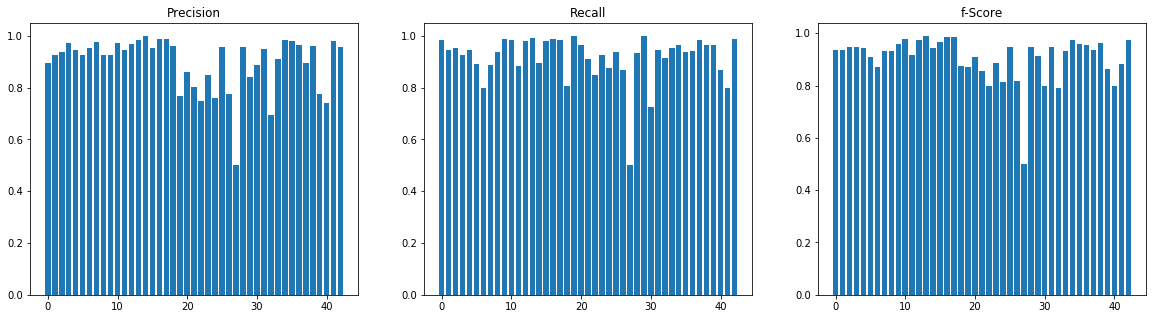

In [13]:
from sklearn.metrics import precision_recall_fscore_support

# convert the test samples to grey-scale
X_grey_test = rgb2gray(X_test)

# normalize the test samples
X_grey_test = (X_grey_test - 128)/128
X_grey_test = np.reshape(X_grey_test, (-1, 32, 32, 1))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    y_pred = sess.run(tf.argmax(logits, 1), feed_dict={x:X_grey_test, keep_prob:1})
    output = precision_recall_fscore_support(y_test, y_pred)
    precision = output[0]
    recall = output[1]
    fscore = output[2]
    
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    ax[0].bar(np.arange(n_classes), precision)
    ax[0].set_title("Precision")

    ax[1].bar(np.arange(n_classes), recall)
    ax[1].set_title("Recall")

    ax[2].bar(np.arange(n_classes), fscore)
    ax[2].set_title("f-Score")
    
    smallest_5_precision_idx = precision.argsort()
    smallest_5_recall_idx = recall.argsort()
    smallest_5_fscore_idx = fscore.argsort()
    print("smallest_5_precision_idx", smallest_5_precision_idx[0:5])
    print("smallest_5_recall_idx", smallest_5_recall_idx[0:5])
    print("smallest_5_fscore_idx", smallest_5_fscore_idx[0:5])
